In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from linear_opt.lin_metabolism import MW_C_ATOM
from linear_opt.lin_metabolism import LinearMetabolicModel
from linear_opt.lin_metabolism import GrowthRateOptParams
from matplotlib import pyplot as plt
from os import path

colors = viz.plotting_style()
lin_colors = colors.values()
plt.style.use('style.mpl')

color_order = ['green', 'blue', 'red', 'purple', 'yellow', 'dark_green', 'dark_blue', 'dark_brown']
lin_colors = [colors[c] for c in color_order]

# Approximate concentrations and ratios for plotting
# Based on Bennett et al. 2009 measurements in E. coli
DEFAULT_ATP = 1.4e-6
DEFAULT_NADH = 1.2e-7
DEFAULT_RE = 10
DEFAULT_RA = 0.3

In [2]:
phi_df = pd.read_csv('../output/Fig2A_variable_lambda.csv')
zcorg_sensitivity_df = pd.read_csv('../output/Fig2B_variable_ZCred.csv')

auto_comp_df = pd.read_csv('../output/Fig2C_autotrophy_comparison.csv')
hetero_gamma_df = auto_comp_df[auto_comp_df['model'] == 'heterotrophy']
auto_gamma_df = auto_comp_df[auto_comp_df['model'] == 'autotrophy']

estimated lambda_max: 25.92
actual lambda_max: 0.6299997892172131


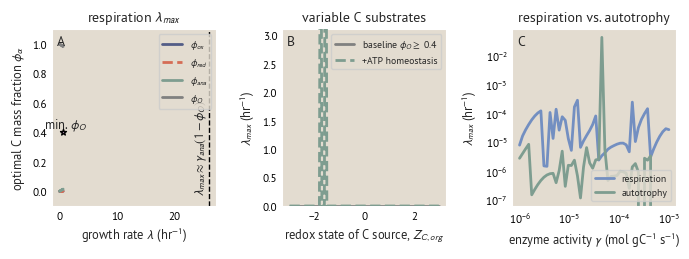

In [4]:
# Notice that phi_O increases as lambda decreases
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(7, 2.7))

# Estimate lambda_max from simple relationships
min_phi_O = 0.4
g_ana = phi_df.anabolism_gamma.values[0]
est_lambda_max = 12*3600*g_ana*(1-min_phi_O)
lambda_max = phi_df.lambda_hr.max()
print('estimated lambda_max:', est_lambda_max)
print('actual lambda_max:', lambda_max)

plt.sca(axs[0])

# Line at min_phi_O
min_phi_O = 0.4
plt.plot([0, lambda_max], [min_phi_O, min_phi_O], 
         color='grey', ls='-.', lw=1)
plt.text(1.1, min_phi_O+0.03, r'min. $\phi_O$', ha='center', fontsize=9)

x = phi_df['lambda_hr']
# Not plotting homeostasis because it was set to zero
cmap = dict(oxidation=colors['dark_blue'],
            reduction=colors['red'],
            anabolism=colors['dark_green'],
            other='grey')
processes = 'oxidation,reduction,anabolism'.split(',')
process_labels = dict(
    oxidation=r'$\phi_{ox}$',
    reduction=r'$\phi_{red}$',
    anabolism=r'$\phi_{ana}$',
    other=r'$\phi_O$')
phi_cols = ['{}_phi'.format(p) for p in processes] + ['phi_O']
for i, col in enumerate(phi_cols):
    label = processes[i] if i < len(processes) else r'other'
    legend_label = process_labels[label]
    c = cmap[label]
    ls = '--' if label == 'reduction' else '-'
    plt.plot(x, phi_df[col], label=legend_label, color=c, ls=ls)
plt.scatter([lambda_max], [min_phi_O], color=colors['purple'], edgecolor='k', marker='*', zorder=10, s=20)

plt.axvline(est_lambda_max, color='k', ls='--', lw=1) 
plt.text(est_lambda_max-0.02, 0.3, r'$\lambda_{max} \approx \gamma_{ana}(1-\phi_O)$', ha='right', va='center', rotation=90, fontsize=9)
plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel(r'optimal C mass fraction $\phi_\alpha$')   
plt.legend(loc=1)
plt.ylim(-0.1, 1.1)

plt.sca(axs[1])
phi_H_included = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == False]
no_phi_H = zcorg_sensitivity_df[
    zcorg_sensitivity_df['opt.max_phi_H_set'] == True]

plt.plot(no_phi_H.ZCorg, no_phi_H.lambda_hr, color='grey',
         label=r'baseline $\phi_O \geq$ {0:.1f}'.format(min_phi_O))
plt.plot(phi_H_included.ZCorg, phi_H_included.lambda_hr,
         color=colors['dark_green'], ls='--',
         label=r'+ATP homeostasis', zorder=10)

plt.legend(loc=1)
plt.ylim(0, 3.1)
plt.xlabel('redox state of C source, $Z_{C,org}$')
plt.ylabel(r'$\lambda_{max}$ (hr$^{-1}$)')

plt.sca(axs[2])
plt.xscale('log')
plt.yscale('log')
plt.plot(hetero_gamma_df.anabolism_gamma, hetero_gamma_df.lambda_hr,
         color=colors['blue'], label='respiration')
plt.plot(auto_gamma_df.anabolism_gamma, auto_gamma_df.lambda_hr,
         color=colors['dark_green'], label='autotrophy')
plt.xlabel('enzyme activity $\gamma$ (mol gC$^{-1}$ s$^{-1}$)')
plt.ylabel(r'$\lambda_{max}$ (hr$^{-1}$)')
plt.legend(loc=4)

titles = 'respiration $\lambda_{max}$,variable C substrates,respiration vs. autotrophy'.split(',')
for title, label, ax in zip(titles, 'ABC', axs):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top')
    ax.set_title(title)
    
plt.tight_layout()
plt.savefig('../output/model_growth_limits.png', facecolor='white', bbox_inches='tight', dpi=300)
plt.show()